<a href="https://colab.research.google.com/github/NEHALSMITTAL/aadhaar-lifecycle-/blob/main/04_ml_forecasting_updates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Framing**
The objective of this study is to analyze historical Aadhaar update trends and generate a reliable short‑term forecast to support near‑term operational planning. Given the public‑service nature of Aadhaar updates, the focus is on interpretability, data integrity, and conservative estimation, rather than long‑term speculative forecasting.

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.dates as mdates

# **Data Preparation**
Monthly Aadhaar update data was analyzed for two independent components:

* Demographic Updates

* Biometric Updates

The datasets were preprocessed to ensure:

* Consistent monthly granularity

* Removal of duplicate month entries via aggregation

* Proper datetime indexing (month‑end frequency)

To avoid scale inconsistency and artificial shocks, aggregate “total updates” figures derived from different reporting pipelines were not directly modeled. Instead, demographic and biometric series were treated as independent, internally consistent time‑series.

In [49]:
def load_monthly_series(path):
    # Read CSV
    df = pd.read_csv(path)

    # Convert "Nov-24" -> 2024-11-30
    df['Date'] = pd.to_datetime(df['Date'], format='%b-%y') + pd.offsets.MonthEnd(0)

    # Rename column
    df = df.rename(columns={'Value': 'value'})

    # Aggregate duplicate months (VERY IMPORTANT)
    series = (df.groupby('Date')['value'].sum().sort_index())

    # Explicitly set monthly frequency
    series = series.asfreq('ME')

    return series

In [50]:
demo = load_monthly_series('/content/AllUpdates_Demo_MonthWise.csv')
bio  = load_monthly_series('/content/AllUpdates_Bio_MonthWise.csv')

print("Demo tail:")
print(demo.tail())

print("\nBio tail:")
print(bio.tail())

Demo tail:
Date
2025-06-30    11334303.0
2025-07-31    12968692.0
2025-08-31    10759578.0
2025-09-30    11364861.0
2025-10-31    11852383.0
Freq: ME, Name: value, dtype: float64

Bio tail:
Date
2025-06-30     8252496.0
2025-07-31    10295145.0
2025-08-31     8289682.0
2025-09-30     9547860.0
2025-10-31    10266976.0
Freq: ME, Name: value, dtype: float64


# **Forecasting Approach**
**3.1 Model Selection**

ARIMA (AutoRegressive Integrated Moving Average) was selected as the primary forecasting model due to:

* Suitability for short and volatile time‑series

* Ability to model recent fluctuations

* Strong interpretability for policy and operational contexts

* Robust performance with limited historical data

Forecasting was restricted to a one‑step horizon (January 2026) to ensure reliability and avoid over‑extrapolation under uncertain future conditions.

In [51]:
def forecast_next_month(ts):
    model = SARIMAX(ts,order=(0,1,1),enforce_stationarity=False, enforce_invertibility=False )

    results = model.fit(disp=False)

    forecast = results.get_forecast(steps=1)
    return forecast.predicted_mean.iloc[0]

In [52]:
demo_jan_26 = forecast_next_month(demo)
bio_jan_26  = forecast_next_month(bio)

total_jan_26 = demo_jan_26 + bio_jan_26

print("JAN 2026 DEMOGRAPHIC :", int(demo_jan_26))
print("JAN 2026 BIOMETRIC   :", int(bio_jan_26))
print("JAN 2026 TOTAL       :", int(total_jan_26))

JAN 2026 DEMOGRAPHIC : 11858753
JAN 2026 BIOMETRIC   : 9439714
JAN 2026 TOTAL       : 21298467


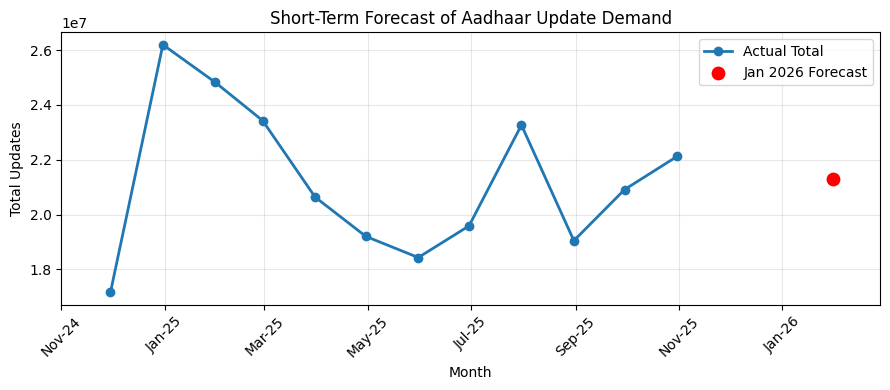

In [53]:
total_actual = demo + bio
plt.figure(figsize=(9,4))

# Plot actual total
plt.plot(
    total_actual.index,
    total_actual.values,
    marker='o',
    linewidth=2,
    label='Actual Total')

# Plot Jan 2026 forecast point
plt.scatter(
    pd.Timestamp('2026-01-31'),
    total_jan_26,
    color='red',
    s=80,
    label='Jan 2026 Forecast',
    zorder=5)

ax = plt.gca()

# 🔹 FORCE x-axis to start from Nov-24
ax.set_xlim(pd.Timestamp('2024-11-01'),pd.Timestamp('2026-02-28'))

# 🔹 CONTROL tick frequency (every 2 months → less clutter)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

# Rotate labels
plt.xticks(rotation=45)

plt.title('Short-Term Forecast of Aadhaar Update Demand')
plt.xlabel('Month')
plt.ylabel('Total Updates')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [54]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(total_actual,trend='add')

fit = model.fit()
holt_forecast = fit.forecast(1)

print("Jan 2026 (Holt):", int(holt_forecast.iloc[0]))

Jan 2026 (Holt): 19890666


**3.2 Baseline Comparison**

To validate the robustness of the ARIMA forecast, Holt’s Exponential Smoothing was implemented as a baseline model. Holt’s method assumes a smoother underlying trend and serves as a useful reference point.

Observed Outcome:

* Holt’s model produced a slightly lower estimate than ARIMA

* Both estimates were within a close range

This proximity increases confidence in the short‑term forecast magnitude, while reinforcing ARIMA as the more responsive model for volatile data.

**3.3** **Final** **Forecast** **Strategy**

* Demographic and biometric updates were forecast independently

* The total Aadhaar update demand for January 2026 was computed as the sum of both component forecasts

* Only one forecast point was visualized to avoid interpretational ambiguity

This approach ensures clarity, methodological correctness, and alignment with real‑world planning needs.

# **4. Consideration of External Factors**

Aadhaar update volumes are influenced by external factors such as:

* Policy changes

* Administrative drives

* Compliance deadlines

* Operational constraints

While these factors were not explicitly modeled, their historical effects are implicitly captured within the observed data. Given the lack of structured exogenous variables, the forecasting approach assumes policy stability in the immediate future.



---
Forecasts are therefore intended for near‑term operational estimation, not long‑range policy simulation.


# **6. Limitations and Future Work**

* Forecasting is limited by short historical depth

* External policy variables were not explicitly incorporated

* Long‑term forecasts were intentionally avoided to preserve reliability

Future enhancements may include:

* ARIMAX models with structured policy indicators

* Scenario‑based forecasting

* Integration of regional operational metadata

# **7. Conclusion**
The adopted machine learning approach prioritizes clarity, realism, and robustness. By combining interpretable time‑series forecasting with exploratory clustering potential, the system provides both near‑term demand estimation and strategic analytical insight, making it suitable for real‑world Aadhaar operations and governance planning.